# IA353 - Redes Neurais
# EFC3 - Questão 5 - Parte 2

### **Considerações iniciais:**
- Neste *notebook* é apresentado a aplicação de um autoencoder com camadas convolucionais para reconstrução de imagens do *dataset* CIFAR10.

### **Estrutura do *dataset* CIFAR10:**
- O *dataset* CIFAR10 é formando por 60000 imagens de treinamento e 10000 imagens de teste, todas com dimensão 32x32x3 e pertencentes a uma dentre as 10 classes a seguir:
  - Aeronave, carro, pássaro, gato, veado, cachorro, sapo, cavalo, navio e caminhão.

- As classes são balanceadas, sendo que cada uma possui 6000 amostras no conjunto de treinamento.

### **Arquitetura e treinamento da rede neural:**

- **Arquitetura:**
  - Codificador:
    - Duas camadas convolucionais cada uma com 64 kernels de dimensão 4x4 e funções de ativação LeakyReLU, seguidas por camada de MaxPooling de dimensão 2x2.
    - Uma camada convolucional com 32 kernels de dimensão 3x3 e funções de ativação LeakyReLU, seguida por uma camada de MaxPooling de dimensão 2x2.
    - Uma camada densa com 512 neurônios com funções de ativação LeakyReLU.
    - Uma camada densa com 200 neurônios com funções de ativação linear (Gargalo do autoencoder).

  - Decodificador:
    - Duas camadas densas com, respectivamente, 512 e 2048 neurônios com funções de ativação do tipo LeakyReLU.
    - Uma camada convolucional com 32 kernels de dimensão 2x2 e funções de ativação LeakyReLU, seguida por uma camada de UpSampling de dimensão 2x2.
    - Duas camadas convolucionais cada uma com 64 kernels de dimensão 2x2 e funções de ativação LeakyReLU, com uma camada de UpSampling de dimensão 2x2 entre elas.
    - Uma camada convolucional com 3 kernels de dimensão 2x2 e funções de ativação sigmoide (saída do autoencoder).

- **Treinamento:**
  - Algoritmo de otimização: Adam
  - Função custo: Erro quadrático médio (MSE)
  - Minibatches com 128 amostras
  - Número de épocas: 50

- **Observações:**

  - Diferente da parte 1 da questão 5, um autoencoder formado apenas por camadas fully-connected não se mostrou adequado nesta questão. Assim, optou-se por utilizar um autoencoder com camadas convolucionais.

  - Devido a maior complexidade do problema, foi necessário utilizar um *manifold* com dimensão maior. Nesse autoencoder convolucional o *manifold* possui dimensão 200x1.

  - Como o modelo apresenta um número elevado de camadas, a função de ativação LeakyReLU mostrou ser mais adequada do que a ReLU no treinamento.

  - A última camada do autoencoder possui 3 kernels convolucionais para que a sua saída apresentasse o mesmo número de canais que as imagens de entrada (3 canais - RGB).

### **Análises:**

- A função custo (*loss*) atingiu um valor baixo após as 50 épocas de treinamento, assumindo um valor de 0.0033. Esse resultado mostra que a flexibilidade do modelo foi suficiente para a resolução do problema.

- Com relação às imagens reconstruídas pelo autoencoder, elas apresentam cores bem semelhantes as das imagens originais, porém a resolução (no sentido de qualidade) apresentada é pior. Mesmo assim, é possível identificar visualmente a quais classes cada uma das imagens reconstruídas pertencem.


## **Imports**


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

## **Reading the data**


In [ ]:
# Download do dataset:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

# Normalização dos dados de entrada para que fiquem no intervalo [0, 1]:
x_train, x_test = x_train / 255.0, x_test / 255.0

# x_train.shape = (50000, 28, 28) --- y_train.shape = (50000, 1)
# x_test.shape  = (10000, 28, 28) --- y_test.shape  = (10000, 1)

In [ ]:
# Definition of a function to visualize some images
def show(img):
    plt.imshow(img, interpolation = "none")

## **Parte 1: Arquitetura e treinamento:**


### **1.1. Arquitetura:**

In [ ]:
INPUT_SHAPE = x_train.shape[1::]

# Encoder:
input_img = keras.Input(shape=INPUT_SHAPE)

encoded = keras.layers.Conv2D(64, kernel_size=(4, 4), padding='same')(input_img)
encoded = keras.layers.LeakyReLU()(encoded)
encoded = keras.layers.Conv2D(64, kernel_size=(4, 4), padding='same')(encoded)
encoded = keras.layers.LeakyReLU()(encoded)
encoded = keras.layers.MaxPooling2D(pool_size=(2, 2))(encoded)
encoded = keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same')(encoded)
encoded = keras.layers.LeakyReLU()(encoded)
encoded = keras.layers.MaxPooling2D(pool_size=(2, 2))(encoded)

encoded = keras.layers.Flatten()(encoded)
encoded = keras.layers.Dense(512)(encoded)
encoded = keras.layers.LeakyReLU()(encoded)

encoded = keras.layers.Dense(200)(encoded) # Linear activation function at the bottleneck

# Decoder:
decoded = keras.layers.Dense(512)(encoded)
decoded = keras.layers.LeakyReLU()(decoded)
decoded = keras.layers.Dense(2048)(decoded)
decoded = keras.layers.LeakyReLU()(decoded)

decoded = keras.layers.Reshape(target_shape=(8, 8, 32))(decoded)
decoded = keras.layers.Conv2D(32, kernel_size=(2, 2), padding='same')(decoded)
decoded = keras.layers.LeakyReLU()(decoded)
decoded = keras.layers.UpSampling2D(size=(2, 2))(decoded)
decoded = keras.layers.Conv2D(64, kernel_size=(2, 2), padding='same')(decoded)
decoded = keras.layers.LeakyReLU()(decoded)
decoded = keras.layers.UpSampling2D(size=(2, 2))(decoded)
decoded = keras.layers.Conv2D(64, kernel_size=(2, 2), padding='same')(decoded)
decoded = keras.layers.LeakyReLU()(decoded)
decoded = keras.layers.Conv2D(3, kernel_size=(2, 2), activation='sigmoid', padding='same')(decoded)

# Autoencoder:
autoencoder = keras.Model(inputs=input_img, outputs=decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        65600     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464 

### **1.2. Treinamento:**

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 50

X = x_train.reshape(x_train.shape)

autoencoder.compile(optimizer = "adam", loss = "mse")
history = autoencoder.fit(X, X, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, verbose = 1)

Epoch 1/50
391/391 [==============================] - 11s 29ms/step - loss: 0.0182
Epoch 2/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0090
Epoch 3/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0074
Epoch 4/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0067
Epoch 5/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0062
Epoch 6/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0058
Epoch 7/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0056
Epoch 8/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0054
Epoch 9/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0052
Epoch 10/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0050
Epoch 11/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0049
Epoch 12/50
391/391 [==============================] - 11s 28ms/step - loss: 0.0048
E

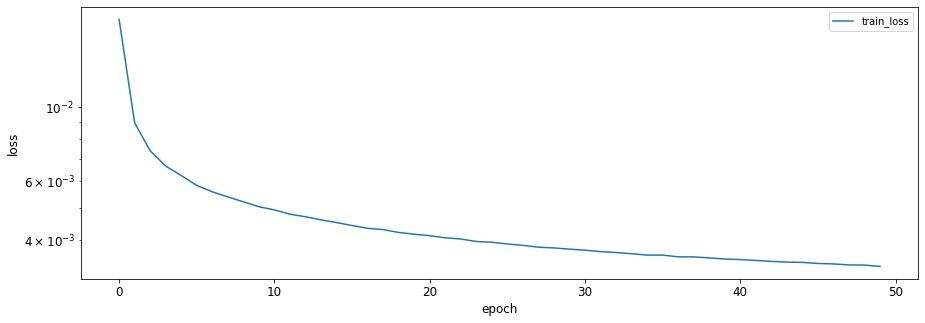

In [ ]:
# Gráfico da perda em função do número de épocas:
 
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

### **1.3. Obtenção do codificador e do decodificador após o treinamento:**

In [ ]:
# Encoder:
encoder = keras.Model(inputs = input_img, outputs = encoded)
encoder.summary()

# Decoder:
encoded_input = keras.Input(shape=(200,))

for i in range(-14, 0):
    encoded_layer = autoencoder.layers[i]
    if i == -14:
        decoder = encoded_layer(encoded_input)
    else:
        decoder = encoded_layer(decoder)


decoder = keras.Model(inputs=encoded_input, outputs=decoder)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        65600     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        1846

### **1.4. Visualização de imagens de treinamento originais e reconstruídas:**

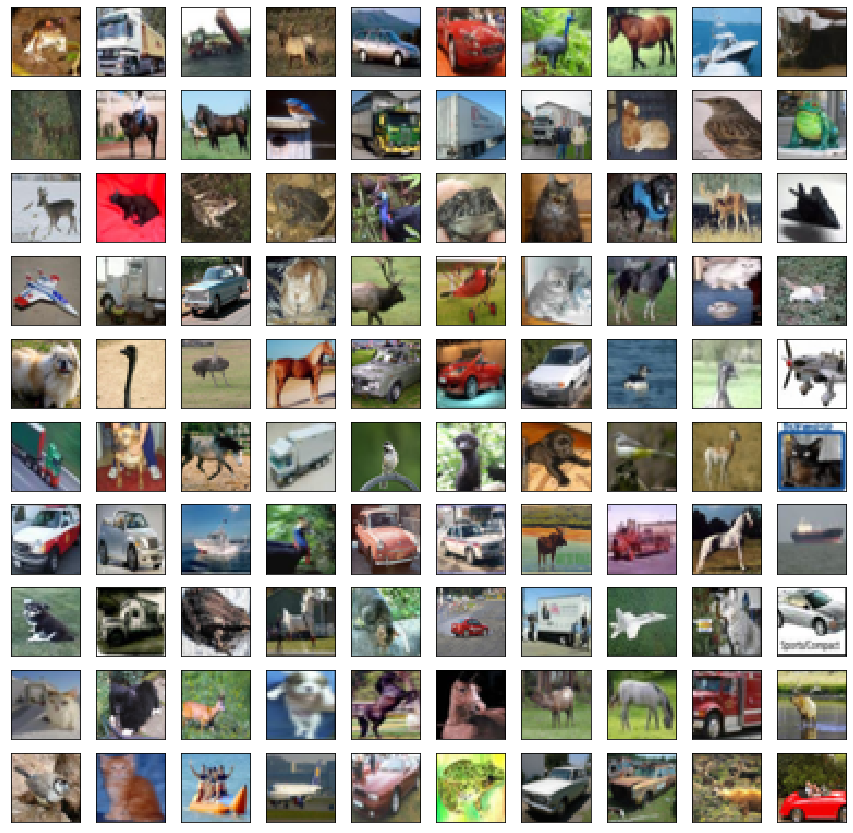

In [ ]:
# Visualization of 10 x 10 original images
N = 10

fig = plt.figure(figsize=(15,15))
ind = 0
for i in range(1, N+1, 1):
    for j in range(1, N+1, 1):
        fig.add_subplot(N, N, ind+1)
        show(x_train[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

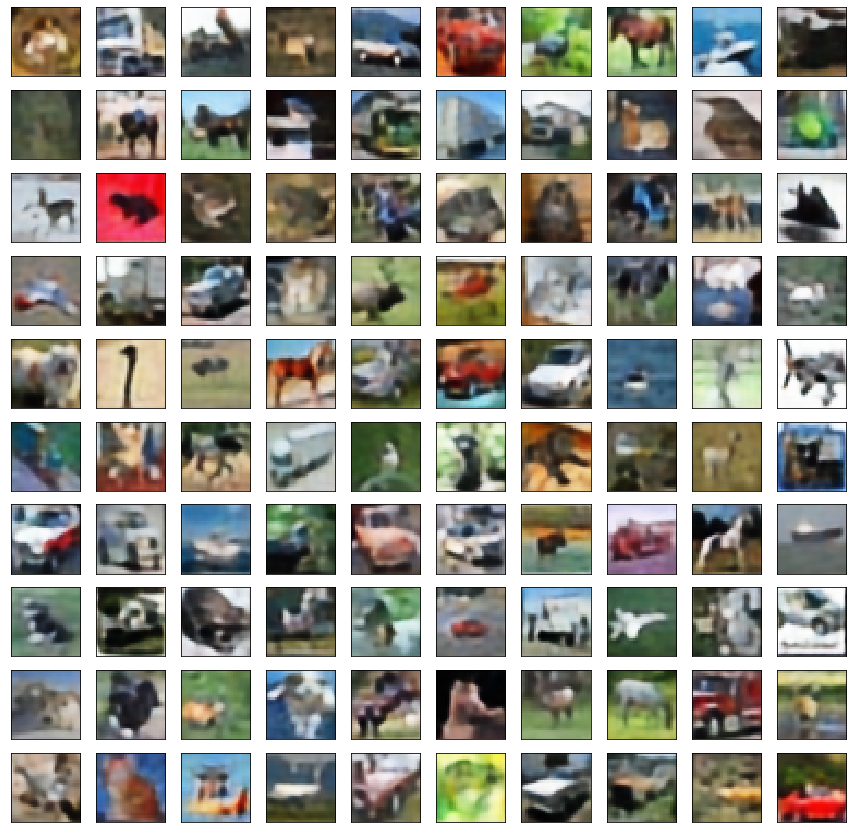

In [ ]:
# Visualization of 20 x 20 reconstructed images

x_predict = autoencoder.predict(X[:N*N])

fig = plt.figure(figsize=(15,15))
ind = 0
for i in range(1, N+1, 1):
    for j in range(1, N+1, 1):
        fig.add_subplot(N, N, ind+1)
        show(x_predict[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1